In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

![](nbeats_architecture.PNG)

# BUILDING THE N-BEATS BLOCK CELL

In [2]:
class blocks(tf.keras.layers.Layer):
    def __init__(self,
                 number_neurons:int,
                 number_layers:int,
                 window_size:int,
                 horizon_size:int,
                 theta_size:int,
                 **kwargs): #**kwargs takes care of the arguements of the parent class(input_size)
        super().__init__(**kwargs)
        self.hidden_neurons = number_neurons
        self.hidden_layers = number_layers
        self.output_size = horizon_size
        self.input_size = window_size
        self.theta_size = theta_size
        
        self.fc_layers = [tf.keras.layers.Dense(self.hidden_neurons, activation = "relu") for _ in range(self.hidden_layers)]
        self.theta_layer = tf.keras.layers.Dense(self.theta_size, name = "theta")
    def call(self, inputs):
        x = inputs 
        for i in self.fc_layers:
            x = i(x)
        outputs = self.theta_layer(x)
        backcasts, forecasts = outputs[:,:self.input_size], outputs[:,-int(self.output_size):]
        return backcasts, forecasts

In [10]:
# testing the block layer
trial_data = tf.expand_dims(tf.range(7),axis=0).numpy()
block = blocks(number_neurons = 512,
                 number_layers = 4,
                 window_size = 7,
                 horizon_size = 1,
                 theta_size = 8, # theta_size = window_size(backcast) + horizon_size(forecast)
              )
backcasts, forecasts = block(trial_data)
backcasts, forecasts

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 0.17283726, -0.3287056 , -0.17393354,  0.05655561, -0.00181248,
         -0.09732629,  0.17259817]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01073312]], dtype=float32)>)

# PREPARING THE DATA FOR N-BEATS ARCHITECTURE

In [4]:
df = pd.read_csv("BTC_USD_2014-11-04_2021-12-03-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145
...,...,...,...,...,...
2021-11-29,BTC,57303.185972,54784.900000,57461.551028,53359.800000
2021-11-30,BTC,57834.357549,57305.932502,58890.733509,56770.710000
2021-12-01,BTC,56973.182042,57834.367211,59223.380063,55948.430857


In [5]:
df_cp = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {'Closing Price (USD)':'Price'})
df_cp.head(10)

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753
2014-11-09,344.745289
2014-11-10,357.239982
2014-11-11,371.116917
2014-11-12,366.664633


In [6]:
# making windows
window_size = 7
horizon = 1
df_cp_win = df_cp.copy()
for i in range(window_size):
    df_cp_win[f'Price + {i+1}'] = df_cp["Price"].shift(periods = i+1,axis=0)
x = df_cp_win.dropna().drop("Price",axis=1).astype(np.float32)
y = df_cp_win.dropna()["Price"].astype(np.float32)

In [25]:
# splitting in train and test
split_size = int(len(x)*0.8)
xtrain, ytrain = x[:split_size], y[:split_size]
xtest, ytest = x[split_size:], y[split_size:]
len(xtrain), len(ytrain), len(xtest), len(ytest)

(2064, 2064, 516, 516)

In [8]:
# using tf.data.Dataset api to fasten the process
xtrain = tf.data.Dataset.from_tensor_slices(xtrain)
ytrain = tf.data.Dataset.from_tensor_slices(ytrain)
xtest = tf.data.Dataset.from_tensor_slices(xtest)
ytest = tf.data.Dataset.from_tensor_slices(ytest)
# zipping the data together into train_df and test_df
train_df = tf.data.Dataset.zip((xtrain,ytrain))
test_df = tf.data.Dataset.zip((xtest,ytest))
# dividing the data into batches
batch_size = 1024
train_df = train_df.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_df = test_df.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_df,test_df

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)>)

# SETTING UP HYPERPARAMETERS

![](hyperparameters_img.PNG)

In [9]:
batch_size = 1024
number_neurons = 512
number_layers = 4
epochs = 5000
number_stacks = 30
input_size = 7
output_size = 1
theta_size = 8

# BUILDING, FITTING AND COMPILING THE MODEL

In [17]:
# building the model
tf.random.set_seed(42)
block1 = blocks(number_neurons,
                 number_layers,
                 input_size,
                 output_size,
                 theta_size)
stack_inputs = tf.keras.layers.Input(shape = (input_size))
backcasts,forecasts = block1(stack_inputs)
residual = tf.keras.layers.subtract([stack_inputs,backcasts])
for i,_ in enumerate(range(number_stacks-1)):
    backcasts, block_forecasts = blocks(number_neurons,
                                 number_layers,
                                 input_size,
                                 output_size,
                                 theta_size)(residual)
    residual = tf.keras.layers.subtract([residual, backcasts])
    forecasts = tf.keras.layers.add([forecasts, block_forecasts])
model_nbeats = tf.keras.models.Model(inputs = stack_inputs, outputs = forecasts)
# compiling the model
model_nbeats.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])
# fitting the model
history = model_nbeats.fit(train_df,
            epochs = epochs,
            validation_data=test_df, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        patience=200, 
                                                        restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                           patience=100, 
                                                           verbose=1)])

Epoch 1/5000
3/3 [==============================] - 6s 588ms/step - loss: 64903.7656 - mae: 64903.7656 - mse: 9400024064.0000 - val_loss: 12793.5254 - val_mae: 12793.5254 - val_mse: 212102304.0000 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 130ms/step - loss: 5953.7725 - mae: 5953.7725 - mse: 81835432.0000 - val_loss: 2770.1003 - val_mae: 2770.1003 - val_mse: 12958205.0000 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 129ms/step - loss: 2364.7810 - mae: 2364.7810 - mse: 12693603.0000 - val_loss: 1801.6337 - val_mae: 1801.6337 - val_mse: 6636599.5000 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 81ms/step - loss: 377.1464 - mae: 377.1464 - mse: 446360.9062 - val_loss: 4130.6606 - val_mae: 4130.6606 - val_mse: 28566004.0000 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 92ms/step - loss: 817.9261 - mae: 817.9261 - mse: 1605557.0000 - val_loss: 16147.8662 - val_mae: 16147.8662 - val_mse: 335001664.000

Epoch 42/5000
3/3 [==============================] - 0s 133ms/step - loss: 240.6970 - mae: 240.6970 - mse: 182803.5000 - val_loss: 1244.8326 - val_mae: 1244.8326 - val_mse: 3250263.5000 - lr: 0.0010
Epoch 43/5000
3/3 [==============================] - 0s 79ms/step - loss: 230.4883 - mae: 230.4883 - mse: 182202.9062 - val_loss: 1444.5386 - val_mae: 1444.5386 - val_mse: 4592009.5000 - lr: 0.0010
Epoch 44/5000
3/3 [==============================] - 0s 79ms/step - loss: 162.0086 - mae: 162.0086 - mse: 109727.7266 - val_loss: 1450.0452 - val_mae: 1450.0452 - val_mse: 3997380.2500 - lr: 0.0010
Epoch 45/5000
3/3 [==============================] - 0s 135ms/step - loss: 165.0178 - mae: 165.0178 - mse: 108832.2891 - val_loss: 1244.2340 - val_mae: 1244.2340 - val_mse: 3252164.0000 - lr: 0.0010
Epoch 46/5000
3/3 [==============================] - 0s 132ms/step - loss: 152.7189 - mae: 152.7189 - mse: 101264.0469 - val_loss: 1205.9692 - val_mae: 1205.9692 - val_mse: 3047660.7500 - lr: 0.0010
Epoch 4

3/3 [==============================] - 0s 87ms/step - loss: 138.0269 - mae: 138.0269 - mse: 81460.1562 - val_loss: 1181.4595 - val_mae: 1181.4595 - val_mse: 2921774.5000 - lr: 0.0010
Epoch 84/5000
3/3 [==============================] - 0s 80ms/step - loss: 161.6511 - mae: 161.6511 - mse: 95268.0078 - val_loss: 1198.0554 - val_mae: 1198.0554 - val_mse: 3131699.0000 - lr: 0.0010
Epoch 85/5000
3/3 [==============================] - 0s 82ms/step - loss: 217.7075 - mae: 217.7075 - mse: 156266.8750 - val_loss: 1161.7050 - val_mae: 1161.7050 - val_mse: 2858511.0000 - lr: 0.0010
Epoch 86/5000
3/3 [==============================] - 0s 78ms/step - loss: 210.6139 - mae: 210.6139 - mse: 137303.6094 - val_loss: 1226.3019 - val_mae: 1226.3019 - val_mse: 3084076.0000 - lr: 0.0010
Epoch 87/5000
3/3 [==============================] - 0s 80ms/step - loss: 165.5495 - mae: 165.5495 - mse: 106170.4844 - val_loss: 1238.0079 - val_mae: 1238.0079 - val_mse: 3495097.5000 - lr: 0.0010
Epoch 88/5000
3/3 [=======

3/3 [==============================] - 0s 79ms/step - loss: 145.5621 - mae: 145.5621 - mse: 86373.7109 - val_loss: 1177.9950 - val_mae: 1177.9950 - val_mse: 2925624.5000 - lr: 0.0010
Epoch 125/5000
3/3 [==============================] - 0s 87ms/step - loss: 140.2546 - mae: 140.2546 - mse: 83388.2891 - val_loss: 1135.9016 - val_mae: 1135.9016 - val_mse: 2800855.2500 - lr: 0.0010
Epoch 126/5000
3/3 [==============================] - 0s 79ms/step - loss: 148.4190 - mae: 148.4190 - mse: 88738.7578 - val_loss: 1126.6178 - val_mae: 1126.6178 - val_mse: 2768150.2500 - lr: 0.0010
Epoch 127/5000
3/3 [==============================] - 0s 87ms/step - loss: 143.4333 - mae: 143.4333 - mse: 86770.4062 - val_loss: 1140.2914 - val_mae: 1140.2914 - val_mse: 2794820.0000 - lr: 0.0010
Epoch 128/5000
3/3 [==============================] - 0s 79ms/step - loss: 153.0499 - mae: 153.0499 - mse: 88582.9297 - val_loss: 1130.9641 - val_mae: 1130.9641 - val_mse: 2827667.2500 - lr: 0.0010
Epoch 129/5000
3/3 [=====

3/3 [==============================] - 0s 82ms/step - loss: 175.3947 - mae: 175.3947 - mse: 118172.1875 - val_loss: 1180.5273 - val_mae: 1180.5273 - val_mse: 2965691.7500 - lr: 0.0010
Epoch 166/5000
3/3 [==============================] - 0s 80ms/step - loss: 162.5971 - mae: 162.5971 - mse: 102661.9844 - val_loss: 1216.6450 - val_mae: 1216.6450 - val_mse: 3045203.0000 - lr: 0.0010
Epoch 167/5000
3/3 [==============================] - 0s 82ms/step - loss: 150.8165 - mae: 150.8165 - mse: 95188.0703 - val_loss: 1148.3418 - val_mae: 1148.3418 - val_mse: 2846938.5000 - lr: 0.0010
Epoch 168/5000
3/3 [==============================] - 0s 81ms/step - loss: 142.2083 - mae: 142.2083 - mse: 87457.2578 - val_loss: 1131.8839 - val_mae: 1131.8839 - val_mse: 2756701.2500 - lr: 0.0010
Epoch 169/5000
3/3 [==============================] - 0s 81ms/step - loss: 144.9854 - mae: 144.9854 - mse: 90583.6484 - val_loss: 1152.8459 - val_mae: 1152.8459 - val_mse: 2835669.5000 - lr: 0.0010
Epoch 170/5000
3/3 [===

3/3 [==============================] - 0s 86ms/step - loss: 157.5266 - mae: 157.5266 - mse: 93583.3359 - val_loss: 1210.9584 - val_mae: 1210.9584 - val_mse: 3280391.5000 - lr: 0.0010
Epoch 207/5000
3/3 [==============================] - 0s 88ms/step - loss: 153.2974 - mae: 153.2974 - mse: 101244.1562 - val_loss: 1712.5026 - val_mae: 1712.5026 - val_mse: 5155163.5000 - lr: 0.0010
Epoch 208/5000
3/3 [==============================] - 0s 92ms/step - loss: 271.5791 - mae: 271.5791 - mse: 195022.8438 - val_loss: 1598.2910 - val_mae: 1598.2910 - val_mse: 5279088.0000 - lr: 0.0010
Epoch 209/5000
3/3 [==============================] - 0s 91ms/step - loss: 380.4325 - mae: 380.4325 - mse: 395764.3125 - val_loss: 1865.0840 - val_mae: 1865.0840 - val_mse: 6953830.0000 - lr: 0.0010
Epoch 210/5000
3/3 [==============================] - 0s 88ms/step - loss: 169.4789 - mae: 169.4789 - mse: 110942.6406 - val_loss: 1576.1250 - val_mae: 1576.1250 - val_mse: 4646644.0000 - lr: 0.0010
Epoch 211/5000
3/3 [=

3/3 [==============================] - 0s 90ms/step - loss: 311.0628 - mae: 311.0628 - mse: 265468.8750 - val_loss: 1206.7263 - val_mae: 1206.7263 - val_mse: 3113506.7500 - lr: 0.0010
Epoch 248/5000
3/3 [==============================] - 0s 83ms/step - loss: 261.8365 - mae: 261.8365 - mse: 218555.7344 - val_loss: 1279.6572 - val_mae: 1279.6572 - val_mse: 3457537.0000 - lr: 0.0010
Epoch 249/5000
3/3 [==============================] - 0s 84ms/step - loss: 197.0463 - mae: 197.0463 - mse: 143775.9688 - val_loss: 1629.5013 - val_mae: 1629.5013 - val_mse: 4883765.5000 - lr: 0.0010
Epoch 250/5000
3/3 [==============================] - 0s 81ms/step - loss: 172.3016 - mae: 172.3016 - mse: 118721.0625 - val_loss: 1261.4215 - val_mae: 1261.4215 - val_mse: 3354998.5000 - lr: 0.0010
Epoch 251/5000
3/3 [==============================] - 0s 81ms/step - loss: 157.0458 - mae: 157.0458 - mse: 108302.6641 - val_loss: 1285.9977 - val_mae: 1285.9977 - val_mse: 3318437.2500 - lr: 0.0010
Epoch 252/5000
3/3 [

Epoch 287/5000
3/3 [==============================] - 0s 84ms/step - loss: 130.1994 - mae: 130.1994 - mse: 80035.6328 - val_loss: 1092.4685 - val_mae: 1092.4685 - val_mse: 2650571.0000 - lr: 1.0000e-04
Epoch 288/5000
3/3 [==============================] - 0s 82ms/step - loss: 130.1163 - mae: 130.1163 - mse: 79855.0703 - val_loss: 1092.0326 - val_mae: 1092.0326 - val_mse: 2650042.2500 - lr: 1.0000e-04
Epoch 289/5000
3/3 [==============================] - 0s 80ms/step - loss: 129.9202 - mae: 129.9202 - mse: 79758.1719 - val_loss: 1094.3359 - val_mae: 1094.3359 - val_mse: 2654289.7500 - lr: 1.0000e-04
Epoch 290/5000
3/3 [==============================] - 0s 85ms/step - loss: 130.4100 - mae: 130.4100 - mse: 79556.5078 - val_loss: 1098.5648 - val_mae: 1098.5648 - val_mse: 2664997.2500 - lr: 1.0000e-04
Epoch 291/5000
3/3 [==============================] - 0s 82ms/step - loss: 130.2980 - mae: 130.2980 - mse: 79391.2344 - val_loss: 1093.1761 - val_mae: 1093.1761 - val_mse: 2650312.5000 - lr: 1

Epoch 328/5000
3/3 [==============================] - 0s 88ms/step - loss: 126.4149 - mae: 126.4149 - mse: 75448.5078 - val_loss: 1093.6532 - val_mae: 1093.6532 - val_mse: 2639238.0000 - lr: 1.0000e-04
Epoch 329/5000
3/3 [==============================] - 0s 81ms/step - loss: 126.1561 - mae: 126.1561 - mse: 75421.4922 - val_loss: 1094.8359 - val_mae: 1094.8359 - val_mse: 2642354.0000 - lr: 1.0000e-04
Epoch 330/5000
3/3 [==============================] - 0s 88ms/step - loss: 126.2983 - mae: 126.2983 - mse: 75366.2812 - val_loss: 1096.6993 - val_mae: 1096.6993 - val_mse: 2648142.5000 - lr: 1.0000e-04
Epoch 331/5000
3/3 [==============================] - 0s 87ms/step - loss: 126.3484 - mae: 126.3484 - mse: 75335.6797 - val_loss: 1096.5778 - val_mae: 1096.5778 - val_mse: 2647733.2500 - lr: 1.0000e-04
Epoch 332/5000
3/3 [==============================] - 0s 81ms/step - loss: 126.1598 - mae: 126.1598 - mse: 75304.0234 - val_loss: 1098.1985 - val_mae: 1098.1985 - val_mse: 2653451.7500 - lr: 1

Epoch 369/5000
3/3 [==============================] - 0s 81ms/step - loss: 122.6225 - mae: 122.6225 - mse: 71656.6328 - val_loss: 1095.5674 - val_mae: 1095.5674 - val_mse: 2643916.7500 - lr: 1.0000e-04
Epoch 370/5000
3/3 [==============================] - 0s 84ms/step - loss: 122.2586 - mae: 122.2586 - mse: 71519.6016 - val_loss: 1097.9520 - val_mae: 1097.9520 - val_mse: 2649283.2500 - lr: 1.0000e-04
Epoch 371/5000
3/3 [==============================] - 0s 87ms/step - loss: 123.4610 - mae: 123.4610 - mse: 71523.8125 - val_loss: 1098.0015 - val_mae: 1098.0015 - val_mse: 2648979.5000 - lr: 1.0000e-04
Epoch 372/5000
3/3 [==============================] - 0s 84ms/step - loss: 122.3683 - mae: 122.3683 - mse: 71408.4688 - val_loss: 1095.1980 - val_mae: 1095.1980 - val_mse: 2641878.5000 - lr: 1.0000e-04
Epoch 373/5000
3/3 [==============================] - 0s 83ms/step - loss: 122.0423 - mae: 122.0423 - mse: 71345.4141 - val_loss: 1100.4250 - val_mae: 1100.4250 - val_mse: 2658573.5000 - lr: 1

Epoch 409/5000
3/3 [==============================] - 0s 82ms/step - loss: 120.9086 - mae: 120.9086 - mse: 70109.8359 - val_loss: 1100.3029 - val_mae: 1100.3029 - val_mse: 2658475.2500 - lr: 1.0000e-05
Epoch 410/5000
3/3 [==============================] - 0s 85ms/step - loss: 120.9044 - mae: 120.9044 - mse: 70099.7578 - val_loss: 1100.2089 - val_mae: 1100.2089 - val_mse: 2658116.0000 - lr: 1.0000e-05
Epoch 411/5000
3/3 [==============================] - 0s 81ms/step - loss: 120.8784 - mae: 120.8784 - mse: 70088.7500 - val_loss: 1100.2340 - val_mae: 1100.2340 - val_mse: 2658144.7500 - lr: 1.0000e-05
Epoch 412/5000
3/3 [==============================] - 0s 83ms/step - loss: 120.8359 - mae: 120.8359 - mse: 70086.4062 - val_loss: 1100.1406 - val_mae: 1100.1406 - val_mse: 2657659.0000 - lr: 1.0000e-05
Epoch 413/5000
3/3 [==============================] - 0s 81ms/step - loss: 120.8160 - mae: 120.8160 - mse: 70068.0156 - val_loss: 1100.2681 - val_mae: 1100.2681 - val_mse: 2658307.0000 - lr: 1

Epoch 450/5000
3/3 [==============================] - 0s 81ms/step - loss: 120.4383 - mae: 120.4383 - mse: 69715.6719 - val_loss: 1100.7479 - val_mae: 1100.7479 - val_mse: 2661282.0000 - lr: 1.0000e-05
Epoch 451/5000
3/3 [==============================] - 0s 79ms/step - loss: 120.4645 - mae: 120.4645 - mse: 69706.0078 - val_loss: 1100.7603 - val_mae: 1100.7603 - val_mse: 2660958.2500 - lr: 1.0000e-05
Epoch 452/5000
3/3 [==============================] - 0s 82ms/step - loss: 120.4134 - mae: 120.4134 - mse: 69705.3516 - val_loss: 1100.8527 - val_mae: 1100.8527 - val_mse: 2661205.7500 - lr: 1.0000e-05
Epoch 453/5000
3/3 [==============================] - 0s 83ms/step - loss: 120.4119 - mae: 120.4119 - mse: 69688.1250 - val_loss: 1100.9550 - val_mae: 1100.9550 - val_mse: 2661698.5000 - lr: 1.0000e-05
Epoch 454/5000
3/3 [==============================] - 0s 84ms/step - loss: 120.3983 - mae: 120.3983 - mse: 69683.4062 - val_loss: 1100.7883 - val_mae: 1100.7883 - val_mse: 2661011.5000 - lr: 1

In [48]:
model_nbeats.save_weights("nbeats_model")

# EVALUATING THE N-BEATS MODEL

In [18]:
model_nbeats.evaluate(test_df)

1/1 [==============================] - 0s 101ms/step - loss: 1091.0695 - mae: 1091.0695 - mse: 2649196.5000


[1091.0694580078125, 1091.0694580078125, 2649196.5]

In [27]:
from helperfuncs import model_report
preds = tf.squeeze(model_nbeats.predict(test_df)).numpy()
model_nbeats_report = model_report(ytest, preds)
model_nbeats_report

{'MEAN ABSOLUTE ERROR': 1091.0695,
 'MEAN SQUARED ERROR': 2649196.5,
 'ROOT MEAN SQUARED ERROR': 1627.6353,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 2.894559}

# PLOTTING THE PREDICTIONS OF THE N-BEATS MODEL

In [30]:
timesteps = df_cp.index.to_numpy()
timesteps

array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
       '2014-11-06T00:00:00.000000000', ...,
       '2021-12-01T00:00:00.000000000', '2021-12-02T00:00:00.000000000',
       '2021-12-03T00:00:00.000000000'], dtype='datetime64[ns]')

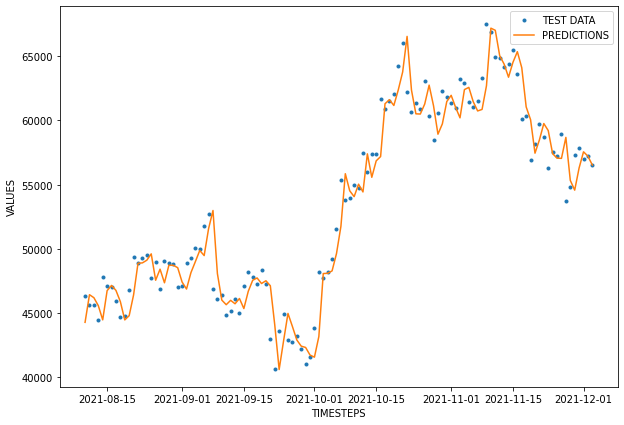

In [34]:
from helperfuncs import plot_timeseries
plt.figure(figsize=(10,7))
plot_timeseries(timesteps[-int(len(ytest)):], ytest, label = "TEST DATA", start = 400)
plot_timeseries(timesteps[-int(len(ytest)):], preds, format = '-', label = "PREDICTIONS", start = 400)